# Анализ показов рекламы 

##### Александр Тиунов
##### 2022 г.

<h1>Оглавление<span class="tocSkip"></span></h1>

*  [Описание бизнес-проблемы](#Описание-бизнес-проблемы)
    -  [Цель](#Цель)
    *  [Бизнес задача](#Бизнес-задача)
    *  [Описание](#Описание)
    *  [Что требуется](#Что-требуется)
*  [Поиск решения](#Поиск-решения)
    *  [Шаг 1: импортируем библиотеки](#Шаг-1:-импортируем-библиотеки)
    *  [Шаг 2: загрузка и изучение данных](#Шаг-2:-загрузка-и-изучение-данных)
    -  [Шаг 3: Подготовка данных](#Шаг-3:-Подготовка-данных)
    *  [Шаг 4: Обработка данных](#Шаг-4:-Обработка-данных)
        * [Проверка выбросов](#Проверка-выбросов)
        * [Распределение средних eCPM-ов юзеров для каждого формата рекламы](#Распределение-средних-eCPM-ов-юзеров-для-каждого-формата-рекламы)
        * [Cредние eCPM по городам для всех видов рекламы](#Cредние-eCPM-по-городам-для-всех-видов-рекламы)
        * [Cредние eCPM по городам для каждого формата рекламы](#Cредние-eCPM-по-городам-для-каждого-формата-рекламы)
        * [Суммарные доходы по городам для каждого формата рекламы](#Суммарные-доходы-по-городам-для-каждого-формата-рекламы)
        * [Диаграмма рассеяния Суммарный доход - Cредний eCPM](#Диаграмма-рассеяния-Суммарный-доход---Cредний-eCPM) 
        * [Cредний eCPM по версиям ОС](#Cредний-eCPM-по-версиям-ОС) 
        * [Cуммарные доходы по версиям ОС](#Cуммарные-доходы-по-версиям-ОС)
        * [Cуммарные доходы по версиям ОС для каждого формата рекламы](#Cуммарные-доходы-по-версиям-ОС-для-каждого-формата-рекламы)
        * [Зависимость прибыли от времени суток](#Зависимость-прибыли-от-времени-суток) 

*  [Выводы](#Выводы)

# Описание бизнес-проблемы

## Цель
* Выявление факторов, влияющих на доход от рекламы

## Бизнес задача

* Провести исследование показов рекламы с целью понять на сколько
отличается eCPM в зависимости от географии (города) юзера, версии ОС и
других параметров. Интересны любые инсайты и находки по eCPM-ам.

## Описание

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
- int – полноэкранная реклама; 
- banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
- rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 

Информация о каждом показе отправляется в аналитику. В нашем распоряжении таблица данных о показах рекламы. 

## Что требуется
* Для каждого формата рекламы:\
a. построить [распределение средних eCPM-ов юзеров](#Распределение-средних-eCPM-ов-юзеров-для-каждого-формата-рекламы)\
b. отобразить [средние eCPM-ы по городам](#Cредние-eCPM-по-городам-для-каждого-формата-рекламы), [версиям ОС](#Cредний-eCPM-по-версиям-ОС) \
c. отобразить [cуммарные доходы по городам](#Суммарные-доходы-по-городам-для-каждого-формата-рекламы), [версиям ОС](#Cуммарные-доходы-по-версиям-ОС)
* [Учесть статистическую значимость](#Проверка-выбросов) для п.1b (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
* [Описать наблюдения и вывод по исследованию.](#Выводы)

# Поиск решения

### Шаг 1: импортируем библиотеки

In [3]:
#import pandas
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

### Шаг 2: загрузка и изучение данных

In [4]:
# read a csv
# Изначально данные можно было загрузить прямо онлайн из drive.google.com
# df = pd.read_csv(r'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1h2eXP4EyL8hYT2kZ0wmShAtp8Qz8HpNq', index_col=False)

df = pd.read_csv(r'data\us events ad_revenue filtered 03.02-07.02.csv')
df.columns = df.columns.str.replace('\s+','_')

C:\Users\User\AppData\Local\Temp/ipykernel_4728/155205292.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('\s+','_')


**Описание полей**

- profile_id – id юзера
- os_version - версия ос
- device_manufacturer - производитель устройства
- device_model - модель устройства
- device_type - тип устройства (смартфон, планшет и т.п)
- device_locale - локация 
- event_name - название события
- event_json - содержит json структуру, в которой:
    - ad_type – формат рекламы (int, banner или rv)
    - placement – когда/где был показ рекламы в игре
    - view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
    - revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
    - ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
    - network_name – рекламная сеть, от которой был показ
    - и др.
- event_datetime и event_timestamp - дата и время ивента
- event_receive_datetime и event_receive_timestamp - (???)
- connection_type - тип соединения
- operator_name - название мобильного оператора
- country_iso_code - код страны
- city - город

Посмотрим на имеющиеся данные

In [5]:
df

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860074,JLSQY2nx1NQ,12,Samsung,Galaxy S21 Ultra 5G,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 08:29:27,1643866167,2022-02-03 08:29:37,1643866177,wifi,Verizon,US,Elmira
860075,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 02:12:51,1643843571,2022-02-03 02:14:48,1643843688,cell,Verizon,US,Cherry Hill
860076,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 02:13:06,1643843586,2022-02-03 02:14:48,1643843688,cell,Verizon,US,Cherry Hill
860077,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 02:13:17,1643843597,2022-02-03 02:14:48,1643843688,cell,Verizon,US,Cherry Hill


###### Судя по значениям часть данных отсутствует\
* profile_id               860065 non-null  object\
* operator_name            841200 non-null  object\
* country_iso_code         860079 non-null  object\
* city                     536371 non-null  object

###### В процентах отсутствующие данные составляют:

In [6]:
print ('***Количество пропусков***')
for column in df.columns:
    print(column ,'= {:.3%}'.format(df[column].isna().sum()/df.shape[0]))

***Количество пропусков***
profile_id = 0.002%
os_version = 0.000%
device_manufacturer = 0.000%
device_model = 0.000%
device_type = 0.000%
device_locale = 0.000%
event_name = 0.000%
event_json = 0.000%
event_datetime = 0.000%
event_timestamp = 0.000%
event_receive_datetime = 0.000%
event_receive_timestamp = 0.000%
connection_type = 0.000%
operator_name = 2.195%
country_iso_code = 0.000%
city = 37.637%


Наибольшее число пропущенных данных city = 37.64%

In [7]:
df.describe(include='object')

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_receive_datetime,connection_type,operator_name,country_iso_code,city
count,860065,860079,860079,860079,860079,860079,860079,860079,860079,860079,860079,841200,860079,536371
unique,4226,11,34,284,2,9,1,860076,322812,180237,3,92,1,920
top,JL5pmKYe8g7,12,Samsung,Galaxy S21 Ultra 5G,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""lose_offer_attem...",2022-02-06 19:00:31,2022-02-06 19:00:32,wifi,Verizon,US,New York
freq,8486,407587,651633,54845,835667,856257,860079,2,555,651,624421,288720,860079,17584


In [8]:
print('Количество дубликатов в данных равно', df.duplicated().sum())

Количество дубликатов в данных равно 0


In [9]:
# проверим event_json
json.loads(df['event_json'][0])

{'ad_type': 'banner',
 'placement': '',
 'view_index': 1,
 'session_view_index': 0,
 'cur_ticks': 637795729492245130,
 'session_length': 705.8807,
 'revenue': 0.000510313,
 'ads_ltv': 0.487876676518837,
 'ecpm_sma': 0.511508107185364,
 'normalized_ecpm_sma': 0.511508107185364,
 'value': 0.000510313,
 'currency': 'USD',
 'ad_country_code': 'US',
 'network_name': 'Google AdMob',
 'ad_unit_id': '64c6b1114ea8c1cc',
 'ad_network_placement': 'ca-app-pub-7511632782617496/8825263691',
 'creativeId': 'CJ3XirfD5vUCFYPnKAUdG3MOYQ'}

### Шаг 3: Подготовка данных

In [10]:
# Переведем тип данных в `datetime`
df['event_datetime'] = pd.to_datetime(df['event_datetime'])

In [11]:
df = df.join(pd.json_normalize(df.event_json.apply(json.loads)))

In [12]:
df

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,...,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,...,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,...,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,...,0.013894,13.782633,13.893784,0.013894,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,...,0.060571,1.660282,1.660282,0.006828,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860074,JLSQY2nx1NQ,12,Samsung,Galaxy S21 Ultra 5G,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 08:29:27,1643866167,...,1.007506,0.080914,0.080914,0.000020,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,165277
860075,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 02:12:51,1643843571,...,0.277541,3.379858,3.379858,0.006740,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMeYrb2S4vUCFZWVyAodrPYHvA
860076,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 02:13:06,1643843586,...,0.280321,3.319878,3.319878,0.002780,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/4884242584,CNrdyMCS4vUCFRNXcgodTqsMOA
860077,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-03 02:13:17,1643843597,...,0.283101,3.265896,3.265896,0.002780,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/4884242584,CJnr0ciS4vUCFQ7HhwodgC8HVw


Посмотрим какие значения есть и проверим на ошибки.

In [13]:
df['ad_type'].unique()

array(['banner', 'int', 'rv'], dtype=object)

In [14]:
df['device_type'].unique()

array(['tablet', 'phone'], dtype=object)

In [15]:
df['city'].nunique()

920

Для 'city'
- Сменим регистр
- Уберем пробел в начале или в конце строки

In [16]:
print(df['city'].str.lower().str.lower().str.strip(' \r').str.lstrip().nunique())
# df['city'].replace([' ', '', 'nan'], np.NaN, inplace=True)

920


Число значений не изменилось, значит, в столбце 'city' данные не требуют очистки.

### Шаг 4: Обработка данных
Для каждого формата рекламы:\
a. построить [распределение средних eCPM-ов юзеров](#Распределение-средних-eCPM-ов-юзеров-для-каждого-формата-рекламы)\
b. отобразить [средние eCPM-ы по городам](#Cредние-eCPM-по-городам-для-каждого-формата-рекламы), [версиям ОС](#Cредний-eCPM-по-версиям-ОС) \
c. отобразить [cуммарные доходы по городам](#Суммарные-доходы-по-городам-для-каждого-формата-рекламы), [версиям ОС](#Cуммарные-доходы-по-версиям-ОС)

### Проверка выбросов

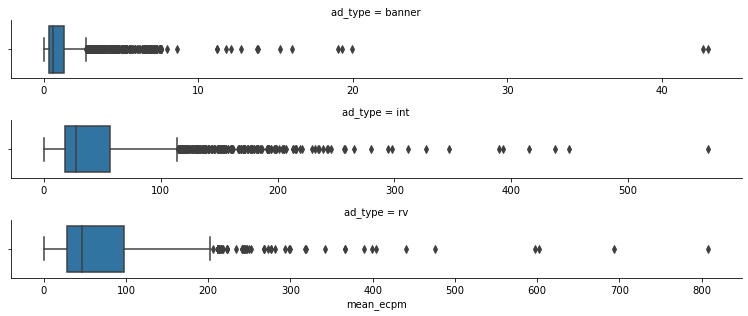

In [17]:
sns.catplot(x='mean_ecpm',
            row='ad_type',
            data=(df.groupby(["ad_type",df["profile_id"]]).revenue.mean()*1000).rename("mean_ecpm").reset_index(),
            kind="box",
            sharex=False,
            aspect=7,
            height=1.5
)

Видим, что для всех типов рекламы наблюдаются выбросы в значениях eCPM. Если важны средние показатели, то эти значения стоит отбросить. 

In [18]:
df_full_screen = df.query('ad_type == "int"')
df_banner = df.query('ad_type == "banner"')
df_video = df.query('ad_type == "rv"')

### Распределение средних eCPM-ов юзеров для каждого формата рекламы

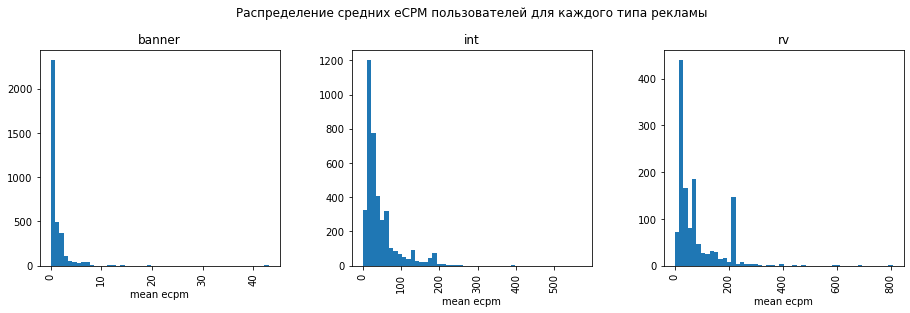

In [19]:
axs = (df.groupby(["ad_type",df["profile_id"]]).revenue.mean()*1000) \
    .hist(bins=50, by='ad_type', figsize=(15,4),layout=(1,3))
for a in axs:
    a.set_xlabel("mean ecpm")
plt.suptitle("Распределение средних eCPM пользователей для каждого типа рекламы",y=1.05);

## Cредние eCPM по городам для всех видов рекламы

Наиболее важной является информация по лидерам дохода, поэтому ограничим список из 920 городов списком ТОП-20 

In [62]:
ecmp_per_city_mean = df.groupby('city')\
.agg({'revenue':'mean'})\
.sort_values(by='revenue', ascending=False)\
.head(20).sort_values(by='revenue')

<AxesSubplot:ylabel='city'>

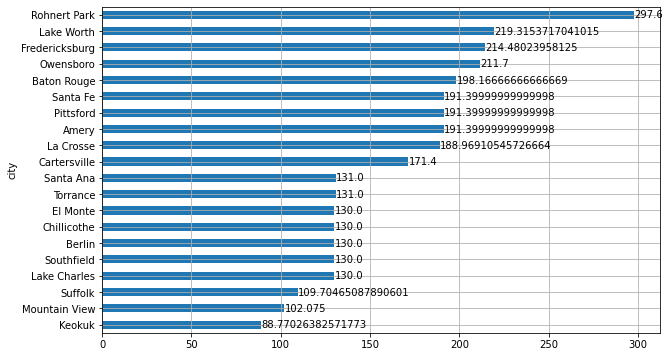

In [63]:
fig, axes = plt.subplots()
for i in range(ecmp_per_city_mean.size):
    a = axes.text(ecmp_per_city_mean["revenue"][i]+(ecmp_per_city_mean["revenue"][i]*1000), 
                  i, ecmp_per_city_mean["revenue"][i]*1000,  
                  verticalalignment='center')
(ecmp_per_city_mean["revenue"]*1000).plot(kind = 'barh', figsize = (10, 6), grid = True)

### Cредние eCPM по городам для каждого формата рекламы

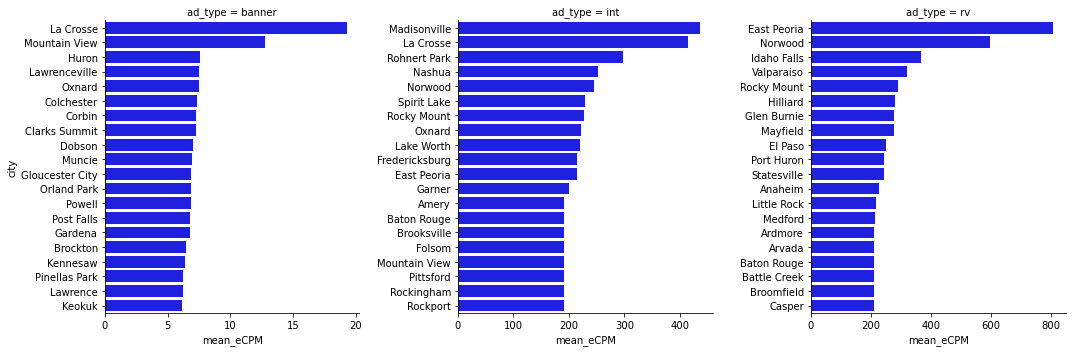

In [60]:
sns.catplot(
    data=(df.groupby(["ad_type",df["city"]]).revenue.mean()*1000).rename("mean_eCPM") \
    .groupby('ad_type', group_keys=False).nlargest(20).reset_index(),
    y='city',
    x='mean_eCPM',
    col='ad_type',
    kind='bar',
    color='blue',
    sharex=False,
    sharey=False
)

В качестве гипотез следует проверить:
1. Средний доход населения по городам;
2. Количество жителей;
3. Количество различных возрастных групп. 

### Суммарные доходы по городам для каждого формата рекламы

C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


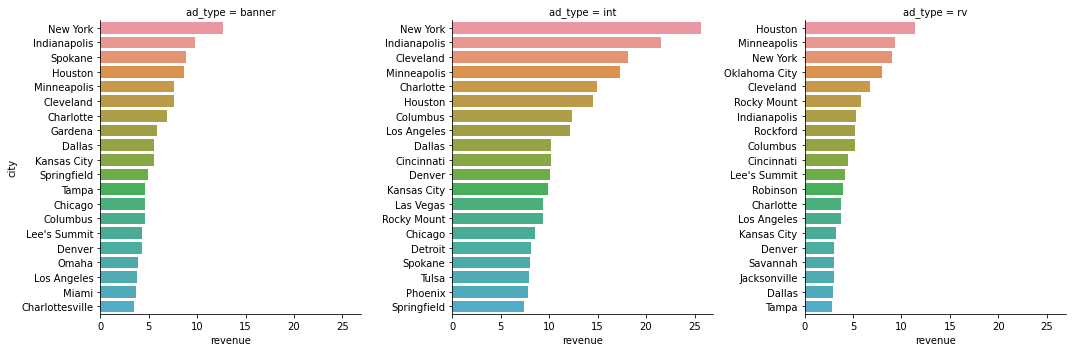

In [65]:
sns.catplot(
    data=(df.groupby(["ad_type",df["city"]], sort=False).revenue.sum()) \
    .groupby('ad_type', group_keys=False).nlargest(20).reset_index(),
    y='city',
    x='revenue',
    col='ad_type',
    kind='bar',
    sharey=False,
    sharex=True
)

Крупные города, такие как New York оказались лидерами по фактическому доходу. При этом список лидеров по доходу отличается от лидеров по среднему eCPM. Чтобы понять, есть ли взаимосвязь реального дохода и среднего eCPM, построим диаграмму рассеяния.

### Диаграмма рассеяния Суммарный доход - Cредний eCPM

In [24]:
df_sum = (df.groupby(["ad_type",df["city"]]).revenue.sum()).rename('total').sort_values(ascending=False).reset_index()
df_mean = df.groupby(["ad_type", df["city"]]).revenue.mean()\
.rename("mean_eCPM").sort_values(ascending=False).reset_index()
df_merge = pd.merge(df_mean, df_sum, on = ('city', 'ad_type'))

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total', ylabel='mean_eCPM'>

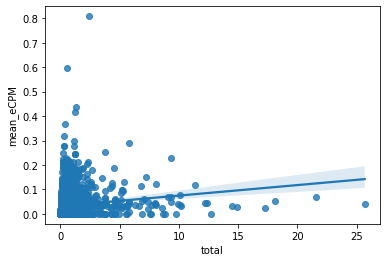

In [25]:
sns.regplot('total', 'mean_eCPM', data=df_merge)

На общих данных не заметно какой-либо корреляции между реальным доходом и средним eCPM. На случай, если имеет место смешение данных, стоит рассмотреть данные для каждого вида рекламы по отдельности.

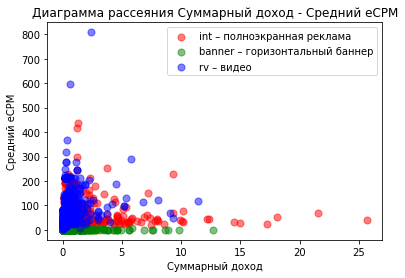

In [26]:
fig, ax = plt.subplots()
ax.scatter(x = df_merge[df_merge['ad_type'] == 'int']['total'], 
           y = df_merge[df_merge['ad_type'] == 'int']['mean_eCPM']*1000, s= 50,
            c = 'r', alpha=0.5)
ax.scatter(x = df_merge[df_merge['ad_type'] == 'banner']['total'], 
           y = df_merge[df_merge['ad_type'] == 'banner']['mean_eCPM']*1000, s= 50,
            c = 'g', alpha=0.5)
ax.scatter(x = df_merge[df_merge['ad_type'] == 'rv']['total'], 
           y = df_merge[df_merge['ad_type'] == 'rv']['mean_eCPM']*1000, s= 50,
            c = 'b', alpha=0.5)
plt.rc('figure', figsize=(10, 6))
ax.set_title('Диаграмма рассеяния Суммарный доход - Cредний eCPM')
ax.set_xlabel('Суммарный доход')
ax.set_ylabel('Cредний eCPM')
ax.legend(['int – полноэкранная реклама','banner – горизонтальный баннер', 'rv – видео'])

Из диаграммы рассеяния видно, что корреляция между реальным доходом и средним eCPM ярко заметна для горизонтального баннера. Для полноэкранной рекламы (int) и видео(rv) данные отображаются хаотично и яркой зависимости между реальным доходом и средним eCPM не показывают. В сочетании с [распределением средних eCPM-ов юзеров для каждого формата рекламы](#Распределение-средних-eCPM-ов-юзеров-для-каждого-формата-рекламы) можно сделать вывод, что в этих видах рекламы есть либо смешение данных, либо ошибка при учете и неправильный ввод исходных данных. \
При смешении данных необходимо:
1. Выявить признаки, которыми отличаются рассматриваемые группы (мобильный оператор, рекламная сеть и т.д.).
2. Разделить группы данных и рассмотреть их по отдельности.\

При выявлении ошибки ввода:
1. Произвести фильтрацию некорректных данных.
2. Рассмотреть отфильтрованные данные.

### Cредний eCPM по версиям ОС

C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


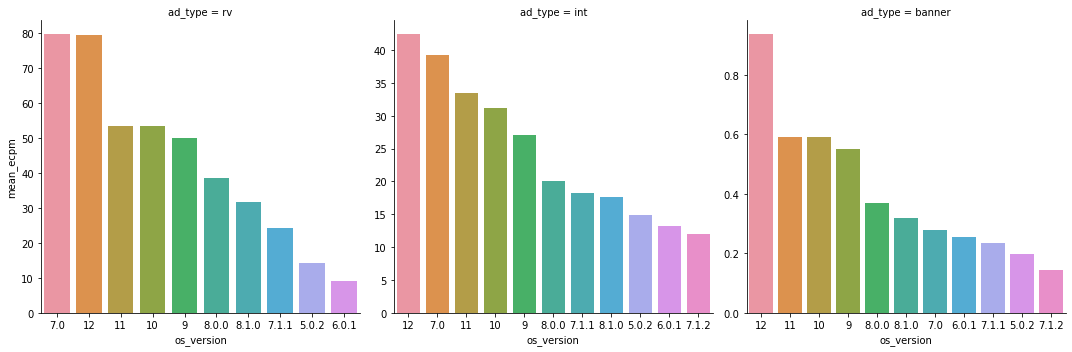

In [27]:
sns.catplot(
    data=(df.groupby(["ad_type","os_version"])
    .revenue.mean().rename("mean_ecpm").sort_values(ascending=False)*1000).reset_index(),
    x='os_version',
    y='mean_ecpm',
    col='ad_type',
    kind='bar',
    sharex=False,
    sharey=False,
)

Очевидно, устройства с версиями Android 7.0, 9, 10, 11, 12 выглядят самыми многообещающими

### Cуммарные доходы по версиям ОС

Мы рассмотрим распределение суммарных доходов по версиям Android, то есть, доход в абсолютном выражении.

In [28]:
grouped_OS = df.groupby(by=['os_version']).agg({'revenue':'sum'}).sort_values(by='revenue', ascending=False)

<AxesSubplot:xlabel='os_version'>

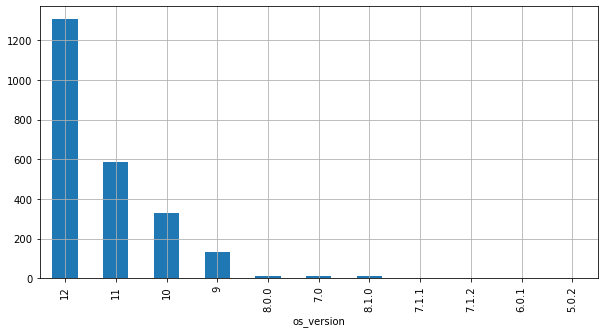

In [29]:
fig, axes = plt.subplots()
grouped_OS["revenue"].plot(kind = 'bar', figsize = (10, 5), grid = True)

Наибольший доход принесли устройства с версиями ОС 9, 10, 11, 12.\
Версия 7.0 несмотря на высокий eCPM в абсолютном выражении существенного вклада в доход не внесла.\
В качестве гипотез для проверки можно предположить возможные причины:
1. Прекращение поддержки старых устройств разработчиками и маркетами;
2. Устройства с операционными системами меньше 9 имеют малый объем памяти и слабый процессор, что не располагает к установке игр;
3. К высокому eCPM версии ОС 7.0 привел не учтенный в исследовании фактор;
4. Покупатели новых устройств более склонны тратить время на игры, чем владельцы менее современных устройств.

### Cуммарные доходы по версиям ОС для каждого формата рекламы

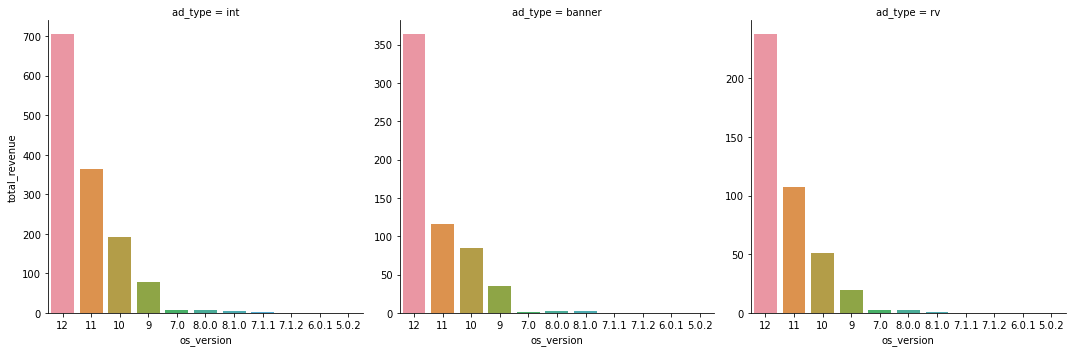

In [30]:
sns.catplot(
    data=(df.groupby(["ad_type",df["os_version"].fillna("no-info")],sort=False)
          .revenue.sum().rename("total_revenue").sort_values(ascending=False)).reset_index(),
    x='os_version',
    y='total_revenue',
    col='ad_type',
    kind='bar',
    sharey=False
)

При рассмотрении дохода от каждого типа рекламы картина не изменилась - наибольший фактический доход приносят устройства с версиями ОС 9, 10, 11, 12. Также определено, что наибольший доход приносит int – полноэкранная реклама, наименьший rv – видео, которое юзер смотрит по желанию.

### Зависимость прибыли от времени суток

Посмотрим, как выглядит распределение событий по времени

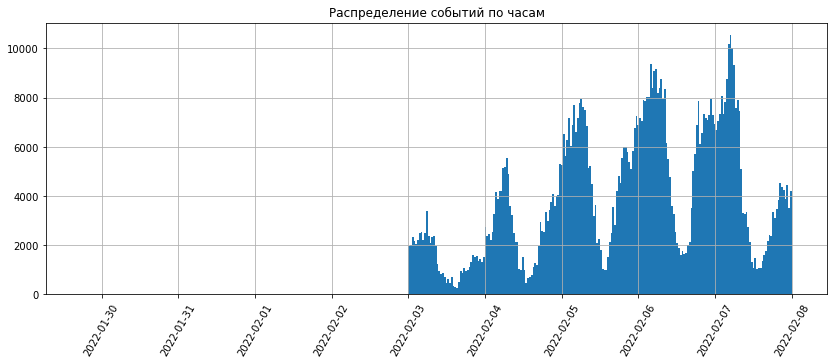

In [31]:
df['event_datetime'].hist(bins=400, figsize=(14, 5)).set_title('Распределение событий по часам')
plt.xticks(rotation=60)
plt.show()

In [32]:
df['event_receive_datetime_hour'] = pd.to_datetime(df['event_datetime']).dt.hour

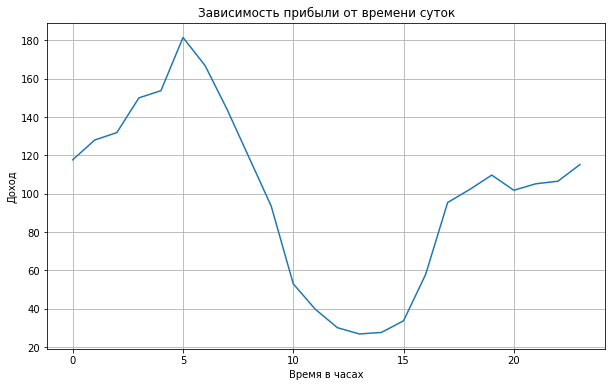

In [38]:
ad_df = df.pivot_table(index = 'event_receive_datetime_hour', values='revenue', aggfunc= 'sum').reset_index()
sns.lineplot(data = ad_df, x = 'event_receive_datetime_hour', y = 'revenue')\
.set(title = 'Зависимость прибыли от времени суток', xlabel = 'Время в часах', ylabel = 'Доход')
plt.grid()

## Выводы

На основании проведенного нами исследования мы можем сделать следующие выводы:

1. Большинство распределений данных являются экспоненциальными, в связи с чем лидеры делают наибольшую часть всей прибыли.
2. Лидерами выручки являются:
* Среди городов: Нью-Йорк, Хьюстон, Миннеаполис;
* Среди версий Android: 12, 11, 10;
* По времени суток: 5 утра;
* По типам рекмы: полноэкранная реклама.

<b>Выводы по анализу eCPM</b>

Картина лидеров по доходу отличается от лидеров по среднему eCPM. 
Из диаграммы рассеяния видно, что корреляция между реальным доходом и средним eCPM ярко заметна только для горизонтального баннера. Для полноэкранной рекламы (int) и видео (rv) данные отображаются хаотично и яркой зависимости между реальным доходом и средним eCPM не показывают. В сочетании с распределением средних eCPM-ов юзеров для каждого формата рекламы можно сделать вывод, что в этих видах рекламы есть либо смешение данных, либо ошибка при учете и неправильный ввод исходных данных.
Необходимо провести дополнительное исследование на предмет смешения или корректности данных.
Если ориентироваться на eCPM, то лидеры: 
* Среди версий Android: 7.0, 12, 11;
* Среди городов: Rohnert Park, Lake Worth, Fredericksburg.

С довольно высокими eCPM эти города могут поднять реальный доход, если увеличится количество просмотров. Это может быть связано с реальными ограничениями, такими как число жителей.

<b>Гипотезы для проверки</b>
1. Причина, по которой современные устройства пользователей приносят больше прибыли;
2. Как влияет на прибыль рекламная сеть, мобильный оператор, производитель устройства и т.д;
3. Влияние количества жителей на количество просмотров рекламы.